# Ntuple preprocessing

**Goal:** Take the root [file]() with track time from Lorenzo, and get it ready for ML studies!!

1. Open the root file
2. Apply some standard FTAG cuts
3. Visualize
4. ML preprocessing


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import h5py

import matplotlib.pyplot as plt

import uproot
import awkward as ak
import xarray as xr

## Step 1: Open the root file

In [4]:
fName = 'data/hadded.root'
f = uproot.open(fName)

In [5]:
for k in f.keys():
    print(k)

EventTree;1
EventLoop_FileExecuted;1
EventLoop_JobStats;1
EventLoop_RunTime;1
EventLoop_EventCount;1


In [6]:
tName = 'EventTree'
t = f[tName]

In [7]:
t.num_entries

48310

OK, this Ntuple has 48k events.

Check what's inside the tree

In [8]:
for k in t.keys():
    print(k)

mcChannelNumber
EventNumber
RunNumber
BCID
mu
muActual
beamspot_x
beamspot_y
beamspot_z
beamspot_sigX
beamspot_sigY
beamspot_sigZ
met_Truth
mpx_Truth
mpy_Truth
sumet_Truth
track_prob
track_d0
track_z0
track_theta
track_phi
track_qOverP
track_t
track_z
track_var_d0
track_var_z0
track_var_phi
track_var_theta
track_var_qOverP
track_cov_d0z0
track_cov_d0phi
track_cov_d0theta
track_cov_d0qOverP
track_cov_z0phi
track_cov_z0theta
track_cov_z0qOverP
track_cov_phitheta
track_cov_phiqOverP
track_cov_tehtaqOverP
track_t30
track_t60
track_t90
track_t120
track_t180
tracks_numPix
tracks_numSCT
tracks_numPix1L
tracks_numPix2L
jet_pt
jet_eta
jet_phi
jet_m
jet_q
jet_ptmatched_pt
jet_ptmatched_eta
jet_ptmatched_phi
jet_ptmatched_m
jet_drmatched_pt
jet_drmatched_eta
jet_drmatched_phi
jet_drmatched_m
jet_isPU
jet_isHS
jet_label
recovertex_x
recovertex_y
recovertex_z
recovertex_sumPt2
recovertex_isPU
recovertex_isHS
truthvertex_x
truthvertex_y
truthvertex_z
truthvertex_t
truthvertex_isPU
truthvertex_isHS
j

OK, we'll want to make separate arrays for the event, jet, track, reco and truth vertex variables.

In [9]:
from itertools import product

In [10]:
numEvts=1500  # Just process a subset of the events in the Ntuple

Note: Currently I can't increase this much larger b/c of SWAN's limit of 16 GB.

But I think a good next step is putting some of this code in this notebook in a little script, b/c it's running pretty fast, so should be able to process all 48k events pretty quickly :)

In [11]:
jet_vars  = ['pt','eta','phi','isHS','label']

jalias = {v:f'jet_{v}' for v in jet_vars}

jdf = t.arrays(jet_vars,library='pd',entry_stop=numEvts,aliases=jalias)

In [12]:
jdf.loc[0]

,pt,eta,phi,isHS,label
subentry,,,,,
0,128.600922,0.824890,2.694299,1,5
1,0.037655,-4.577873,0.729640,0,0
2,52.623814,1.610291,-0.735074,0,0
3,0.037702,-4.220615,-1.494905,0,0
4,22.291336,-1.734767,-2.986814,0,0
5,9.337361,-2.135239,1.522684,0,0
6,0.040433,-2.305586,2.557224,0,0
7,19.228785,1.743958,-1.848075,1,0
8,13.469099,-1.816402,2.518317,0,0


Right, most of these jets are PU and very low $p_T$.

**Goal:** Reshape the track array to _know_ which jet each of the tracks went to.

In [13]:
jet_trk_idx = t.arrays('jet_tracks_idx',entry_stop=numEvts)['jet_tracks_idx']

'''
Right now, `jet_trk_idx` is an awkward array w/ shape (nEvts,nJets,nTrksInJet)
but we'll reshape it to be shape (nEvts*nJets,nTrksInJet) to make it easier to
apply the jet cuts!
'''
jet_trk_idx = ak.concatenate(jet_trk_idx,axis=0)

In [14]:
len(jdf), len(jet_trk_idx)

(48722, 48722)

**Definition of `isPU` and `isHS`**  (from Lorenzo):

- `isHS`: $\Delta R(\text{jet}, \text{truth HS jet}) < 0.3$
- `isPU`: $\Delta R(\text{jet}, \text{truth HS jet}) > 0.6$

**Jet cuts**

Recall what we had from the FlavorTagPerformanceFramework:

- Jets with $p_T > 20$ GeV, $|\eta| < 4$ 
    * Using $|\eta| < 4$ instead of $\eta <2.5$ to be consistent with the GN1 ITk [pub note](http://cds.cern.ch/record/2839913).
- JVT cut (0.2 for pflow jets with pt < 60 GeV and $|\eta| < 2.4$)
    *Instead of a JVT cut, we'll just look at the HS jets. `jet_isHS` are the reco jets within $\Delta R < 0.3$ from a truth jet
- Doesn't overlap with an electron or muon (implemented by the `jet_aliveAfterOR` and `jet_aliveAfterORmu` variables)
    * **TO DO:** Add with the latest ACTS Ntuple (?)


In [15]:
jmask = (jdf['pt'] > 20) & (np.abs(jdf['eta']) < 4) & jdf['isHS'].astype('bool')

In [16]:
jdf = jdf[jmask]
jet_trk_idx = jet_trk_idx[jmask.values]

'''
And then unflatten jet_trk_idx to keep the same (nEvts, njets, nTrksInJet)
shape as before
'''
njets = np.array([len(jdf.loc[i,'pt']) for i in range(numEvts)])
jet_trk_idx = ak.unflatten(jet_trk_idx,counts=njets)

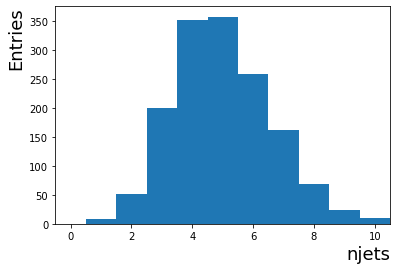

In [17]:
nb=11
r =(-0.5,10.5)
plt.hist(njets,nb,r)

plt.xlabel('njets',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
plt.xlim(r)

plt.show()

In [18]:
# Subset of the track vars (needed for training dips and / or GN1/2)
tVars = [f'd0','z0','var_d0', 'var_z0','qOverP','theta','phi','numPix','numSCT']

In [19]:
jet_trk_idx

<Array [[[1057, 1039, 1181, ... 1126, 1393]]] type='1500 * var * var * int64'>

**To do:** Plot the maximum number of tracks in each jet to decide where to truncate.

In [20]:
nTrks = ak.num(ak.flatten(jet_trk_idx))

In [21]:
# Check the dimensionality
len(nTrks),len(jdf)

(7526, 7526)

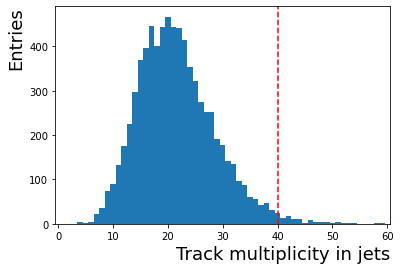

In [22]:
maxNumTrks = 40

nb=61
r =(-0.5,60.5)
plt.hist(nTrks,nb,r)

ylim = plt.ylim()
plt.plot([maxNumTrks]*2,ylim,'r--')
plt.ylim(ylim)
plt.xlim(r)

plt.xlabel('Track multiplicity in jets',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
plt.show()

**Game plan:** 
1. Check the jet -> track association w/ Lorenzo
2. Apply track cuts
3. Apply a sort

**Note:** The way the file is setup now, I'm going to need to do the track -> jet association _before_ applying the track cuts though.

**TO DO** Still need the IPs with respect to the PV.

(Will be in the new ACTS Ntuple.)

In [23]:
iVars = tVars + ['sd0','sz0']
deriv_vars= ['dr','ptfrac']

tnp = np.zeros((len(jdf),maxNumTrks,len(iVars)+len(deriv_vars)))  
tnp.shape

(7526, 40, 13)

In [24]:
trk_vars  = ['d0','z0','theta','phi','qOverP']
trk_vars += [f'var_{v}' for v in trk_vars]
trk_vtrk_vars= ['prob','t','z']  
trk_vars += [f't{n}' for n in [30,60,90,120,180]]

talias = {v: f'track_{v}' for v in trk_vars}

trk_vars += ['numPix','numSCT','numPix1L','numPix2L']
for v in trk_vars[-4:]:
    talias[v] = f'tracks_{v}'

# derived vars 
talias['sd0'] = 'd0/var_d0'
talias['sz0'] = 'z0/var_z0'
talias['pt']  = '0.001 * abs(1/qOverP) * sin(theta)'
talias['eta']  = '- log(tan(theta/2))'

tak = t.arrays(trk_vars+['sd0','sz0','pt','eta'],
               entry_stop=numEvts,aliases=talias)

Look at a couple of intuition plots:

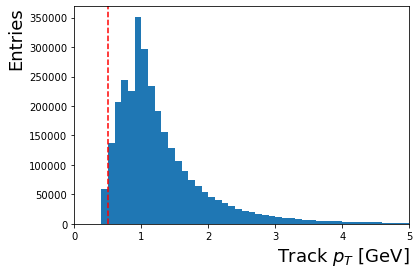

In [25]:
r = (0,5)
plt.hist(ak.flatten(tak['pt']),100,(0,10))
plt.xlabel('Track $p_T$ [GeV]',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
plt.xlim(r)

ylim = plt.ylim()
plt.plot([0.5]*2, ylim, 'r--')
plt.ylim(ylim)

plt.show()

In [26]:
np.min(tak['pt'])

0.4000003

It looks like there's already a $p_T$ > 400 MeV cut in the Ntuple creation.

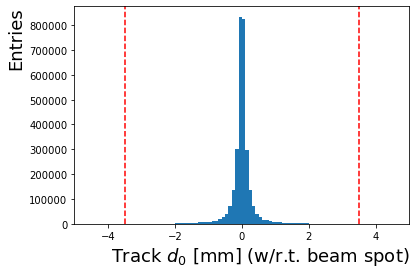

In [27]:
r = (-5,5)
plt.hist(ak.flatten(tak['d0']),100,r)
plt.xlabel('Track $d_0$ [mm] (w/r.t. beam spot)',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
plt.xlim(r)

ylim = plt.ylim()
plt.plot([-3.5]*2, ylim, 'r--')
plt.plot([ 3.5]*2, ylim, 'r--')
plt.ylim(ylim)

plt.show()

A $d_0$ < 3.5 mm cut won't reject too many tracks, even if this $d_0$ is w/r.t. the beam spot instead of the PV.

In [28]:
"""
This has the structure I want: 
nJets, nTrks, nFeatures
"""
tarr = ak.Array([tak_i[jlinks] for tak_i,evt_lev_links in zip(tak,jet_trk_idx) 
                                   for jlinks in evt_lev_links])

In [29]:
idx = ak.argsort(np.abs(tarr["sd0"]),ascending=False)

In [30]:
# Sanity check it worked
abs(tarr[idx]["sd0"][0])

<Array [1.93e+04, 7.6e+03, ... 0.728, 0.419] type='20 * float64'>

In [31]:
# 1. Mask
'''
TO DO: Add the z0 * sin(theta) < 5 mm cut
(and pixel quality cuts? or are those already here?)
'''
tmask = (tarr['pt'] > 0.5) & (abs(tarr['d0']) < 3.5)

# Sort
idx = ak.argsort(np.abs(tarr["sd0"][tmask]),ascending=False)

tarr[tmask][idx]

<Array [{d0: [-0.891, 0.281, ... -0.753]}] type='7526 * {"d0": var * float64, "z...'>

In [32]:
deta = tarr['eta']-jdf['eta']
dphi = np.arcsin(np.sin(tarr['phi']-jdf['phi']))

dr = np.sqrt(deta**2 + dphi**2)

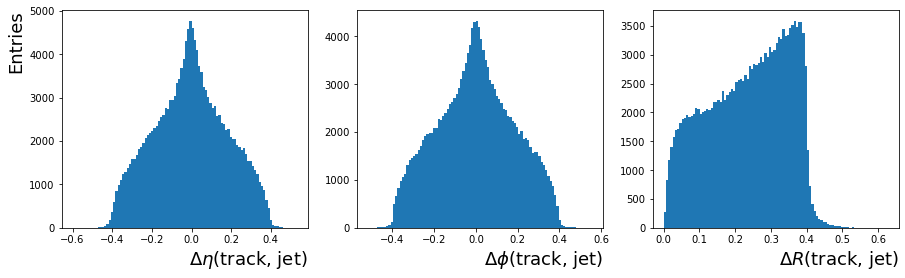

In [33]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].hist(ak.flatten(deta),100)
ax[0].set_xlabel('$\Delta\eta$(track, jet)',fontsize=18,loc='right')
ax[0].set_ylabel('Entries',fontsize=18,loc='top')

ax[1].hist(ak.flatten(dphi),100)
ax[1].set_xlabel('$\Delta\phi$(track, jet)',fontsize=18,loc='right')

ax[2].hist(ak.flatten(dr),100)
ax[2].set_xlabel('$\Delta R$(track, jet)',fontsize=18,loc='right')

plt.show()

Is something suspicious here with $\Delta R$?

In [34]:
ptfrac = tarr['pt']/jdf['pt']

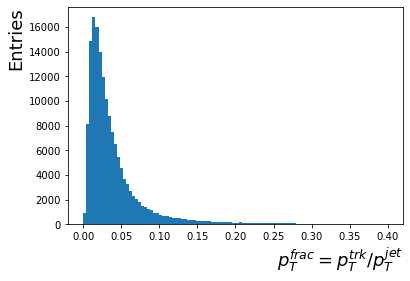

In [35]:
plt.hist(ak.flatten(ptfrac),100,(0,0.4))
plt.xlabel('$p_T^{frac} = p_T^{trk} / p_T^{jet}$',fontsize=18,loc='right')
plt.ylabel('Entries',fontsize=18,loc='top')
# plt.xlim(r)

plt.show()

In [36]:
tVars

['d0', 'z0', 'var_d0', 'var_z0', 'qOverP', 'theta', 'phi', 'numPix', 'numSCT']

In [37]:
assert len(iVars) + 2 == tnp.shape[-1] # Sanity check the dimensions

for i,v in enumerate(iVars):
    padded = ak.fill_none(ak.pad_none(tarr[tmask][idx][v], maxNumTrks, clip=True), 0)
    tnp[:,:,i] = np.asarray(padded)
    
# And now also for the newly derived variables
for k,varr in zip(['ptfrac','dr'],[ptfrac,dr]):
    
    i+=1
    
    padded = ak.fill_none(ak.pad_none(varr[tmask][idx], maxNumTrks, clip=True), 0)
    tnp[:,:,i] = np.asarray(padded)
    

In [38]:
'''
Save to an xarray object (generalization of df for higher dim data)
'''
trk_xr = xr.DataArray(tnp,
                      coords=[('jet',np.arange(len(jdf))),
                              ('trk',np.arange(maxNumTrks)),
                              ('var',iVars+deriv_vars)])


## Visualize the variables we would cut on for the tracks

**Goal:** Plot the track features

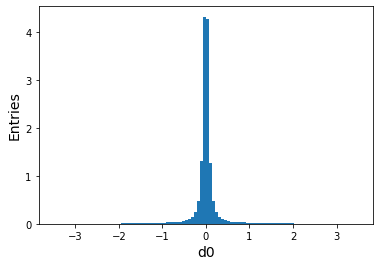

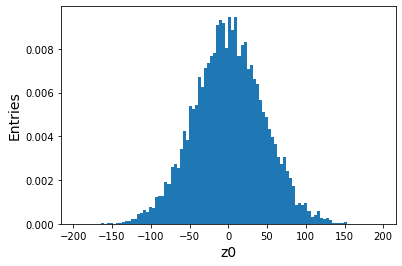

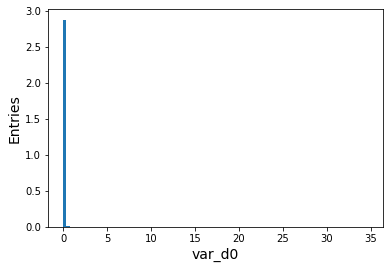

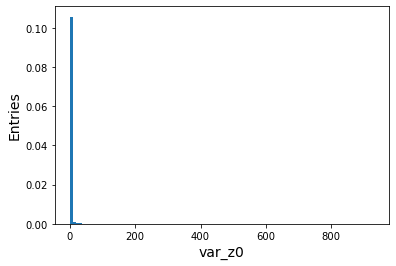

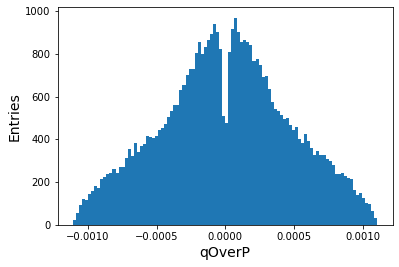

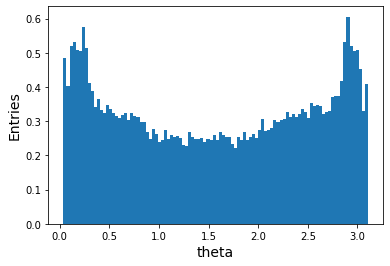

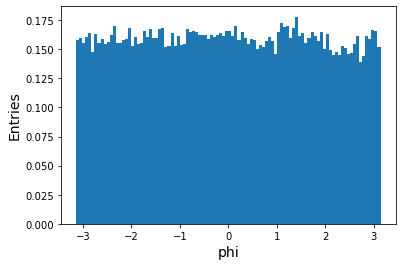

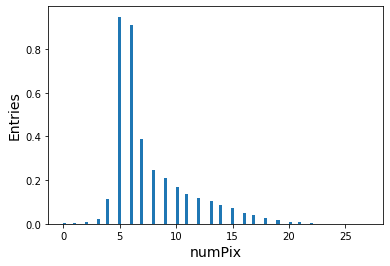

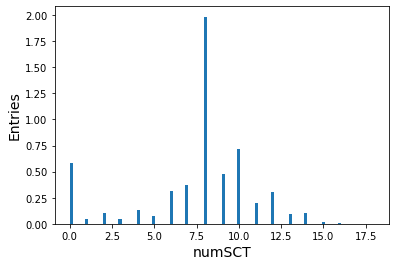

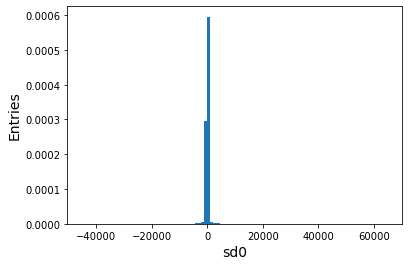

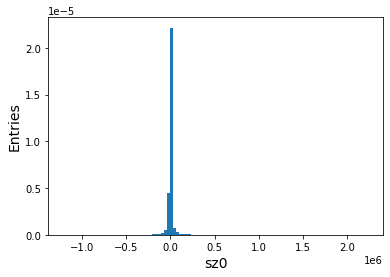

In [39]:
# data has shape (nJets,maxNumTrks,nFeatures), so to sort out the mask,
# we need to find where the value is masked for a track over
# all of it's features.
tmask = ~ np.all(tnp == 0, axis=-1) # shape (nJets,nTrks)

for v in iVars:
    
    plt.figure()
    
    plt.hist(trk_xr.loc[:,:,v].values[tmask],100,density=True)
    plt.xlabel(v,fontsize=14)
    plt.ylabel('Entries',fontsize=14)
    
    plt.show()
    

### ML preprocessing


**Scale the track features**

In [40]:
import json

In [41]:
def scale(data, var_names, savevars, filename='data/trk_scales.json', mask_value=0,
          jetData=None):
    '''
    
    Scaling function for the track features
    
    Args:
    -----
        data: a numpy array of shape (nb_events, nb_particles, n_variables)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testinh
                  it decides whether we want to fit on data to find mean and std
                  or if we want to use those stored in the json file
        filename: string: Where to save the output
        mask_value: the value to mask when taking the avg and stdev

    Returns:
    --------
        modifies data in place, writes out scaling dictionary

    Reference: Taken from Micky's dataprocessing.py file in
    https://github.com/mickypaganini/RNNIP
    '''
    
    scale = {}

    # data has shape (nJets,maxNumTrks,nFeatures), so to sort out the mask,
    # we need to find where the value is masked for a track over
    # all of it's features.
    mask = ~ np.all(data == mask_value, axis=-1) # shape (nJets,nTrks)

    if savevars:

        # track variables
        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}
           
        # Jet variables
        if jetData is not None:
            scaler = StandardScaler(copy=False) # scale the data in place
            scaler.fit_transform(jetData)
            scale['jet_mean'] = scaler.mean_
            scale['jet_scale'] = scaler.scale_
            scale['jet_var'] = scaler.var_
            scale['n_samples_seen'] = scaler.n_samples_seen_
            
        with open(filename, 'w') as varfile:
            json.dump(scale, varfile)

    else:
        with open(filename, 'r') as varfile:
            varinfo = json.load(varfile)

        # track variables
        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')
                        
        if jetData is not None:
            scaler = StandardScaler(copy=False) # scale the data in place
            varinfo['jet_mean'] = scaler.mean_
            varinfo['jet_scale'] = scaler.scale_
            varinfo['jet_var'] = scaler.var_
            varinfo['n_samples_seen'] = scaler.n_samples_seen_
            scaler.transform(jetData)

In [42]:
scaled_tarr = np.copy(tnp)
scale(scaled_tarr,tVars, True)

Scaling feature 1 of 9 (d0).
Scaling feature 2 of 9 (z0).
Scaling feature 3 of 9 (var_d0).
Scaling feature 4 of 9 (var_z0).
Scaling feature 5 of 9 (qOverP).
Scaling feature 6 of 9 (theta).
Scaling feature 7 of 9 (phi).
Scaling feature 8 of 9 (numPix).
Scaling feature 9 of 9 (numSCT).


**Find the jet weights**

Althought GN1 does a "downsampling" procedure, to keep it _simple_ for starting, let's just apply some jet and track level weights.


In [43]:
jdf.head()

pt       eta       phi  isHS  label
entry subentry                                             
0     0         128.600922  0.824890  2.694299     1      5
1     0         313.949249  1.476636  0.305897     1      0
      1         199.966324 -0.246148  2.578580     1      5
      2         188.229691 -1.578895 -1.160125     1      0
      3          87.320175 -0.872998 -1.340151     1      0

In [44]:
def pTReweight(jdf):
    '''
    Do the pT reweighting for the sample, and add a new col 
    `sample_weight` to the dataframe

    Inputs:
    - jdf: pandas dataframe w/ the jet level variables
    '''
    # Set the bin edged
    start, step = 0, 10 # GeV
    stop = np.max(jdf.pt)
    pT_edges = np.arange(start, stop+step, step)

    # Get the bin that each entry corresponds to
    x_ind = np.digitize(jdf.pt, pT_edges) - 1

    # Make the histograms
    l_hist, _ = np.histogram(jdf.loc[jdf.label==0,'pt'].values, bins=pT_edges)
    c_hist, _ = np.histogram(jdf.loc[jdf.label==4,'pt'].values, bins=pT_edges)
    b_hist, _ = np.histogram(jdf.loc[jdf.label==5,'pt'].values, bins=pT_edges)

    # Normalize and add epsilon so that you never get a divide by 0 error
    epsilon = 1e-8
    l_hist = l_hist / np.sum(l_hist) + epsilon
    c_hist = c_hist / np.sum(c_hist) + epsilon
    b_hist = b_hist / np.sum(b_hist) + epsilon

    # Reweight the b-jets and c-jets to the l-jet pT (and maybe later eta) dist 
    jdf['sample_weight'] = np.ones(len(jdf))
    
    for pdg,ref_hist in zip([4,5],[c_hist,b_hist]):
        mi = (jdf.label==pdg)
        jdf.loc[mi,'sample_weight'] = l_hist[x_ind[mi]] / ref_hist[x_ind[mi]]



In [45]:
pTReweight(jdf)

In [46]:
jdf.columns

Index(['pt', 'eta', 'phi', 'isHS', 'label', 'sample_weight'], dtype='object')

**Save to a .h5 file**

In [47]:
'''
MISSING from this Ntuple: nNextToInnHits,nInnHits,nsharedBLHits, nsplitBLHits,
                          nsharedPixHits,nsplitPixHits,nsharedSCTHits
TO DO (later) -- add to noNormVars

ALSO TO DO: d0, z0, sd0 and sz0 need to be w/r.t. PV (instead of beam spot)
'''

# Step 0: Process the string inputs for the vars in each norm sheme -> list
noNormVars = ['sd0','sz0']
logNormVars = ['ptfrac','dr']
jointNormVars = ['numPix', 'numSCT','d0','z0']

# Jet variables to pass to the network
# Default an empty list, but pass pt and eta for GN2
jetVars = []

# Step 1: Select the relevant variables
inpts = noNormVars + logNormVars + jointNormVars

# Check that all of the requested inputs are actually vars in trk_xr
trkInputs = list(trk_xr.coords['var'].values)
for inpt in inpts:
    if inpt not in trkInputs:
        raise ValueError('In prepareForKeras(): requested var {} not in trk_xr'.format(inpt))

X = trk_xr.loc[:,:,inpts].values
X_jet = jdf[jetVars]
ix = trk_xr.indexes['jet']
print("X.shape = ", X.shape)

# Keep track of which tracks in the jet are masked
mask = ~ np.all(X == 0, axis=-1)
print("mask",mask.shape)

# Take the log of the desired variables
for i, v in enumerate(logNormVars):
    j = i + len(noNormVars)
    X[:,:,j][mask] = np.log(np.where(X[:,:,j][mask]==0,1e-8,X[:,:,j][mask]))

# Step 2: Train / test split
pdg_to_class = {0:0, 4:1, 5:2, 15:3}
y = jdf.label.replace(pdg_to_class).values

random_seed = 25
X_train, X_test, y_train, y_test, ix_train, ix_test, w_train, w_test, = \
    train_test_split(X, y, ix, jdf.sample_weight, test_size=0.333,
                     random_state=random_seed)

# Step 3: Normalize the requested inputs

# Get a string representing the variables getting scaled
varTag = "_".join(noNormVars) if len(noNormVars) != 0 else ''
varTag += '_logNorm_' + "_".join(logNormVars) if len(logNormVars) != 0 else ''
varTag += '_norm_' + "_".join(jointNormVars) if len(jointNormVars) != 0 else ''

# Scale the vars and save the files
scalingfile = f"data/scale_{varTag}.json"
print("scalingfile",scalingfile)

if len(logNormVars)+len(jointNormVars) > 0:

    scale(X_train[:,:,len(noNormVars):], logNormVars+jointNormVars, savevars=True,  filename=scalingfile)
    scale(X_test[:,:, len(noNormVars):], logNormVars+jointNormVars, savevars=False, filename=scalingfile)

myDict = {
    "X_train" : X_train,
    "y_train" : y_train,
    "ix_train" : ix_train,
    "weights_train" : w_train,

    "X_test" : X_test,
    "y_test" : y_test,
    "ix_test" : ix_test,
    "weights_test" : w_test,
}

# Step 4: Save as h5py files
outputFile = 'data/output.hdf5'
print("Saving datasets in {}".format(outputFile))
f = h5py.File(outputFile, 'w')

for key, val in myDict.items():
    f.create_dataset(key, data=val)

f.close()

X.shape =  (7526, 40, 8)
mask (7526, 40)
scalingfile data/scale_sd0_sz0_logNorm_ptfrac_dr_norm_numPix_numSCT_d0_z0.json
Scaling feature 1 of 6 (ptfrac).
Scaling feature 2 of 6 (dr).
Scaling feature 3 of 6 (numPix).
Scaling feature 4 of 6 (numSCT).
Scaling feature 5 of 6 (d0).
Scaling feature 6 of 6 (z0).
Scaling feature 1 of 6 (ptfrac).
Scaling feature 2 of 6 (dr).
Scaling feature 3 of 6 (numPix).
Scaling feature 4 of 6 (numSCT).
Scaling feature 5 of 6 (d0).
Scaling feature 6 of 6 (z0).
Saving datasets in data/output.hdf5
